In [1]:
import sys

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
from bez2018model_run_hdf5_dataset import bez2018model

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util
import augment_dataset

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import IPython.display as ipd

import scipy.signal
import scipy.io.wavfile


/om2/user/msaddler/.conda/envs/mdlab/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {'dur': 0.020, 'buffer_start_dur': 0.074, 'buffer_end_dur': 0.0259},
    'ANmodel_params': {'num_cfs': 100, 'min_cf':125, 'max_cf':14e3, 'spont_list':[70.0], 'cohc':1.0},
#     'lpfilter_params': {'order': 6, 'cutoff': 1000.0},
}


sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 200
phase_mode = 'sine'
spectral_region = 'custom'

freq_list = f0*np.arange(1, 60)

if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))

for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)


if spectral_region == 'low':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [125, 625], 'bandpass', filtfilt=True)
elif spectral_region == 'high':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [3900, 5400], 'bandpass', filtfilt=True)
elif spectral_region == 'custom':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [1e2, 1e4], 'bandpass', filtfilt=True)


snr = 12
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = dataset_util.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))
# y = signal
print(signal.shape, noise.shape, y.shape)

ipd.display(ipd.Audio(y, rate=sr))

out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)



(4800,) (4800,) (4800,)


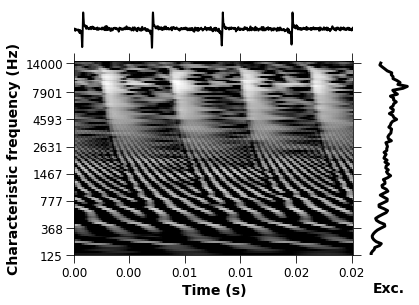

In [9]:
def make_plot(pin_fs, pin, mr_fs, mr, freq,
              figsize=(12, 8),
              xfont=22, yfont=22, tickfont=18,
              min_time=None, max_time=None,
              lw_stimulus=2,
              lw_excitation=4):
    pin = np.squeeze(pin)
    mr = np.squeeze(mr)

    pin_time = np.arange(0, pin.shape[0]) / pin_fs
    mr_time = np.arange(0, mr.shape[1]) / mr_fs
    if (not min_time == None) and (not max_time == None):
        pin_idx = np.squeeze(np.argwhere(np.logical_and(pin_time>=min_time, pin_time<=max_time)))
        mr_idx = np.squeeze(np.argwhere(np.logical_and(mr_time>=min_time, mr_time<=max_time)))
        pin_time = pin_time[pin_idx]
        pin = pin[pin_idx]
        mr_time = mr_time[mr_idx]
        mr = mr[:, mr_idx]

    freq = np.array(freq)
    freq_idx = np.linspace(0, freq.shape[0]-1, 8, dtype=int)
    freq_labels = ['{:.0f}'.format(freq[itr0]) for itr0 in freq_idx]
    time_idx = np.linspace(0, mr_time.shape[0]-1, 6, dtype=int)
    time_labels = ['{:.2f}'.format(mr_time[itr0]) for itr0 in time_idx]

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,
                           gridspec_kw={'height_ratios':[1,5], 'width_ratios':[7,1], 'hspace':0.1, 'wspace':0.1},
                           sharex=False)
    
    ax[0,0].plot(pin_time, pin, 'k-', lw=lw_stimulus)
    ax[0,0].set_xlim([pin_time[0], pin_time[-1]])
    ax[0,0].set_yticks([])
    ax[0,0].set_yticklabels([])
    ax[0,0].get_xaxis().set_visible(False)
    ax[0,0].get_yaxis().set_visible(False)
    ax[0,0].spines["top"].set_visible(False)
    ax[0,0].spines["right"].set_visible(False)
    ax[0,0].spines["bottom"].set_visible(False)
    ax[0,0].spines["left"].set_visible(False)

    ax[1,0].imshow(mr, origin='lower', aspect='auto', extent=[0, mr.shape[1], 0, mr.shape[0]], cmap=cm.gray)
    ax[1,0].set_yticks(freq_idx)
    ax[1,0].set_yticklabels(freq_labels, fontsize=tickfont)
    ax[1,0].set_xticks(time_idx)
    ax[1,0].set_xticklabels(time_labels, fontsize=tickfont)
    ax[1,0].set_xlabel('Time (s)', fontsize=xfont, fontweight='bold')
    ax[1,0].set_ylabel('Characteristic frequency (Hz)', fontsize=yfont, fontweight='bold')
    ax[1,0].tick_params(axis='both', labelsize=tickfont)
    ax[1,0].tick_params(direction='out', axis='both', which='major', length=8, right=True, top=True)
    ax[1,0].tick_params(direction='out', axis='both', which='minor', length=8, right=True, top=True)

    ax[0,1].axis('off')
    
    ax[1,1].plot(np.sum(mr, axis=1), np.arange(0, mr.shape[0]), 'k', lw=lw_excitation)

    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])

    ax[1,1].spines["top"].set_visible(False)
    ax[1,1].spines["bottom"].set_visible(False)
    ax[1,1].spines["right"].set_visible(False)
    ax[1,1].spines["left"].set_visible(False)
    ax[1,1].set_ylim([0, mr.shape[0]])
    ax[1,1].set_xlabel('Exc.', fontsize=xfont, fontweight='bold', labelpad=tickfont+xfont)
#     ax[1,1].spines["bottom"].set_visible(False)
#     ax[1,1].spines["left"].set_visible(False)
    
    plt.show()
    
    return fig, ax


pin_fs = out_dict['pin_fs']
pin = out_dict['pin']
mr_fs = out_dict['meanrates_fs']
mr = out_dict['meanrates']
freq = out_dict['cf_list']
pin_fs = out_dict['pin_fs']
fig, ax = make_plot(pin_fs, pin, mr_fs, mr, freq, figsize=(6, 4.5),
                    xfont=14, yfont=14, tickfont=12,
                    min_time=None, max_time=None,
                    lw_stimulus=2, lw_excitation=3)


cf= 7040.013


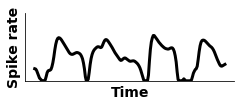

In [11]:

fontsize=14

fidx = 81
print('cf=', freq[fidx])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75, 1.25))

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

ax.plot(mr_time, mr_trace, color='k', lw=3)

# ax.set_xlim([0.0275, 0.0475])
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylim([0, np.max(mr_trace)*1.5])
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)

ax.set_ylabel('Spike rate', fontsize=fontsize, fontweight='bold')
ax.set_xlabel('Time', fontsize=fontsize, fontweight='bold')
plt.show()

